<a href="https://colab.research.google.com/github/MohamedElhedi-BenYedder/DeepLearning.ai-Summary/blob/master/HackForEarth2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as  pd 
import numpy as np 
import os 
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import lightgbm as lgbm

In [2]:
# ! pip install lightgbm 

### Data processing

In [3]:
from google.colab import drive
drive.mount("/content/drive")
path = "/content/drive/MyDrive/Zindi_competition/Hack for Earth /Data"
train = pd.read_csv(path + "/train.csv")
test = pd.read_csv(path + "/test.csv")
submission = pd.read_csv(path+"/sample_sub.csv")

Mounted at /content/drive


In [4]:
train.head()

,ID,AREA_ID,ADM0_NAME,X,Y,year,month,LandcoverCategory_0,LandcoverCategory_1,LandcoverCategory_2,LandcoverCategory_3,LandcoverCategory_4,LandcoverCategory_5,LandcoverCategory_6,LandcoverCategory_7,LandcoverCategory_8,Elevation,unwpp-adjusted_population_density,precipitation,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,target
0,train_0,ID_vWROJUDt,Algeria,6.995371,33.279981,2005,12,0.013001,0.002665,0.000000,0.0,0.000000,0.000018,0.002143,0.980485,0.001688,86.528060,17.873313,0.019999,74.535807,518.330408,-100.016726,592.873187,7.841627,0.184343,0.012119,1207.999761,0.0,49.052457,168.590025,783.912491,61.576092,282.824602,0.000000
1,train_1,ID_ZKFzZgqz,Gabon,13.724646,-1.330817,2005,8,0.000000,0.000000,0.768617,0.0,0.000000,0.000000,0.229401,0.000000,0.001982,492.545597,11.604138,0.005559,372.343805,405.337104,-358.594202,777.665739,9.795414,0.579478,844.948387,1358.890713,0.0,186.291974,271.372161,2379.852515,50.563101,100.540774,0.319102
2,train_2,ID_rAVUdzLu,Burundi,30.322476,-3.457890,2009,5,0.000000,0.000000,0.288423,0.0,0.150904,0.160637,0.398263,0.000000,0.001773,1467.240107,255.956899,0.076401,752.755202,164.797902,-197.958668,917.504966,49.477491,2.445930,1565.676953,1742.273630,0.0,147.633037,255.465414,2005.322129,48.402229,164.096026,0.000000
3,train_3,ID_hQKDcONr,Madagascar,47.864881,-21.346429,2004,9,0.004991,0.000192,0.994396,0.0,0.000000,0.000000,0.000421,0.000000,0.000000,309.266816,79.632118,0.103913,575.156098,437.419633,-311.169996,1012.596054,52.091218,2.547314,189.640383,2054.112779,0.0,161.519643,259.380838,1989.783379,62.074341,196.941930,0.000000
4,train_4,ID_HboSmUHg,Seychelles,55.504306,-4.602603,2017,11,0.093750,0.000000,0.906250,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,8.599265,607.521140,0.127607,1472.996262,0.000000,-79.656075,1472.996262,189.379439,9.379439,458.007477,2414.925234,0.0,249.620561,304.000000,2898.446729,87.000000,434.960748,0.000000


In [5]:
test.head()

,ID,AREA_ID,ADM0_NAME,X,Y,year,month,LandcoverCategory_0,LandcoverCategory_1,LandcoverCategory_2,LandcoverCategory_3,LandcoverCategory_4,LandcoverCategory_5,LandcoverCategory_6,LandcoverCategory_7,LandcoverCategory_8,Elevation,unwpp-adjusted_population_density,precipitation,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs
0,test_0,ID_BrbQaEWf,Tunisia,8.875264,33.284730,2018,3,0.000000,0.007080,0.000178,0.0,0.000000,0.000267,0.004488,0.986165,0.001822,109.912655,7.284470,0.012783,83.017224,1554.791686,-137.333089,1637.808910,8.782397,0.425520,0.149348,2213.028501,0.0,116.805886,248.281718,943.293270,172.133577,546.816831
1,test_1,ID_YDAHwOPt,Democratic Republic of the Congo,23.937944,-4.497663,2018,4,0.000000,0.000000,0.830220,0.0,0.074535,0.000000,0.093957,0.000000,0.001288,598.117146,93.624173,0.258343,1034.022964,74.485313,-994.256714,1108.508277,102.569489,6.308775,655.843532,1966.960063,0.0,194.801714,313.070973,2497.724323,101.949967,126.338276
2,test_2,ID_FmLCJMqr,Uganda,32.424715,1.354910,2018,5,0.063813,0.000000,0.758484,0.0,0.074643,0.002268,0.100793,0.000000,0.000000,1064.121421,60.193603,0.124109,1331.511153,0.992008,-128.265808,1332.503161,185.013491,9.317950,612.001288,2306.107185,0.0,186.374232,296.547769,2379.066834,116.533704,298.278159
3,test_3,ID_QFZjEhdP,Morocco,-7.577399,33.520405,2018,2,0.015878,0.001606,0.001138,0.0,0.000000,0.000000,0.727875,0.000071,0.253431,108.848050,4895.893088,0.092165,562.702290,0.000000,-213.563591,562.702290,69.499029,3.575112,682.141314,1585.012244,0.0,48.975124,181.255708,1114.702460,42.886645,313.903780
4,test_4,ID_NqclFjyy,Seychelles,55.446673,-4.614546,2018,7,0.000000,0.000000,0.780731,0.0,0.000000,0.000000,0.219269,0.000000,0.000000,214.275748,2126.205852,0.032218,589.000000,852.000000,-290.000000,1441.000000,60.000000,3.000000,78.000000,2276.000000,0.0,241.000000,278.000000,2571.000000,76.000000,630.000000


In [6]:
train.shape

(175236, 34)

In [7]:
train["year_month"]=train.year*100+train.month
test["year_month"]=test.year*100+test.month
print(train.year_month.max(),train.year_month.min())
print(test.year_month.max(),test.year_month.min())

201712 200101
201812 201801


In [8]:
X_train=train[train.year!=2017]
X_val=train[train.year==2017]

In [9]:
X_train.columns

Index(['ID', 'AREA_ID', 'ADM0_NAME', 'X', 'Y', 'year', 'month',
       'LandcoverCategory_0', 'LandcoverCategory_1', 'LandcoverCategory_2',
       'LandcoverCategory_3', 'LandcoverCategory_4', 'LandcoverCategory_5',
       'LandcoverCategory_6', 'LandcoverCategory_7', 'LandcoverCategory_8',
       'Elevation', 'unwpp-adjusted_population_density', 'precipitation',
       'climate_aet', 'climate_def', 'climate_pdsi', 'climate_pet',
       'climate_pr', 'climate_ro', 'climate_soil', 'climate_srad',
       'climate_swe', 'climate_tmmn', 'climate_tmmx', 'climate_vap',
       'climate_vpd', 'climate_vs', 'target', 'year_month'],
      dtype='object')

### Training  

In [10]:
def lgbm_model(X_train,X_val,test,features,target_name,params):
    dtrain = lgbm.Dataset(X_train[features],X_train[target_name])
    dval = lgbm.Dataset(X_val[features],X_val[target_name])
    lgbm_model= lgbm.train(params=params,
                train_set=dtrain,
                num_boost_round=num_rounds,
                valid_sets=[dtrain,dval],
                 verbose_eval=verbose_eval,
                 early_stopping_rounds=early_stoping_rounds)
    best_iteration = lgbm_model.best_iteration
    validation_prediction=lgbm_model.predict(X_val[features], num_iteration=best_iteration)
    test_prediction=lgbm_model.predict(test[features], num_iteration=best_iteration)
    return test_prediction ,validation_prediction,lgbm_model

In [11]:
params={'bagging_fraction': 1,
 'bagging_freq': 1,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.9,
 'learning_rate': 0.01,
 'max_depth': 7,
 'metric': 'rmse',
 'min_data_in_leaf': 33,
 'num_leaves': 44,
 'num_threads': 8,
 'objective': 'rmse',
 'seed': 2020,
 'tree_learner': 'serial',
 "verbosity":-1}
num_rounds=1000000
early_stoping_rounds=50
verbose_eval=200


In [12]:
feature_drop=["ID","AREA_ID","ADM0_NAME","year_month","target","year"]
features=[feature for feature in X_train.columns if feature not in  feature_drop ]

In [16]:
test_pred,val_pred,model=lgbm_model(X_train,X_val,test,features,"target",params)

Training until validation scores don't improve for 50 rounds.
[200]	training's rmse: 0.126635	valid_1's rmse: 0.133588
[400]	training's rmse: 0.121588	valid_1's rmse: 0.129993
[600]	training's rmse: 0.119276	valid_1's rmse: 0.128708
[800]	training's rmse: 0.117519	valid_1's rmse: 0.128071
[1000]	training's rmse: 0.116173	valid_1's rmse: 0.127598
[1200]	training's rmse: 0.115014	valid_1's rmse: 0.127237
[1400]	training's rmse: 0.113917	valid_1's rmse: 0.126915
[1600]	training's rmse: 0.112858	valid_1's rmse: 0.126663
[1800]	training's rmse: 0.111935	valid_1's rmse: 0.126497
[2000]	training's rmse: 0.111075	valid_1's rmse: 0.126474
[2200]	training's rmse: 0.110254	valid_1's rmse: 0.126324
[2400]	training's rmse: 0.109395	valid_1's rmse: 0.12616
Early stopping, best iteration is:
[2402]	training's rmse: 0.109389	valid_1's rmse: 0.126158


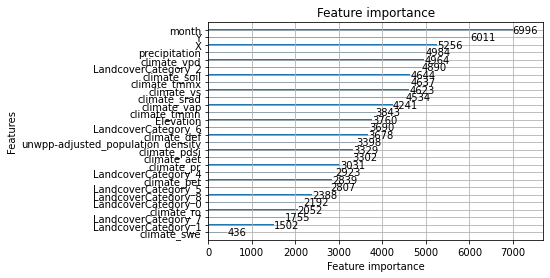

In [17]:
lgbm.plot_importance(model)

In [18]:
sub=test[["ID"]].copy()
sub["target"]=test_pred

In [19]:
sub.to_csv("Sub_numeric_features.csv",index=False)

### Label encoding for AREA_ID , ADM0_NAME

In [20]:
def label_encoding(train,test,column):
    unique_values=pd.concat([train,test])[column].unique()
    map_dict={ k:i for k,i in zip(unique_values,range(len(unique_values)))}
    train[column]=train[column].map(map_dict)
    test[column]=test[column].map(map_dict)    
    return train,test

In [21]:
train,test=label_encoding(train,test,"AREA_ID")
train,test=label_encoding(train,test,"ADM0_NAME")

In [22]:
X_train=train[train.year!=2017]
X_val=train[train.year==2017]

feature_drop=["ID","year_month","target","year"]
features=[feature for feature in X_train.columns if feature not in  feature_drop ]
features

['AREA_ID',
 'ADM0_NAME',
 'X',
 'Y',
 'month',
 'LandcoverCategory_0',
 'LandcoverCategory_1',
 'LandcoverCategory_2',
 'LandcoverCategory_3',
 'LandcoverCategory_4',
 'LandcoverCategory_5',
 'LandcoverCategory_6',
 'LandcoverCategory_7',
 'LandcoverCategory_8',
 'Elevation',
 'unwpp-adjusted_population_density',
 'precipitation',
 'climate_aet',
 'climate_def',
 'climate_pdsi',
 'climate_pet',
 'climate_pr',
 'climate_ro',
 'climate_soil',
 'climate_srad',
 'climate_swe',
 'climate_tmmn',
 'climate_tmmx',
 'climate_vap',
 'climate_vpd',
 'climate_vs']

In [23]:
test_pred,val_pred,model=lgbm_model(X_train,X_val,test,features,"target",params)

Training until validation scores don't improve for 50 rounds.
[200]	training's rmse: 0.12652	valid_1's rmse: 0.13367
[400]	training's rmse: 0.121615	valid_1's rmse: 0.129917
[600]	training's rmse: 0.119217	valid_1's rmse: 0.128542
[800]	training's rmse: 0.117468	valid_1's rmse: 0.127722
[1000]	training's rmse: 0.11608	valid_1's rmse: 0.127184
[1200]	training's rmse: 0.114755	valid_1's rmse: 0.126792
[1400]	training's rmse: 0.113668	valid_1's rmse: 0.126473
[1600]	training's rmse: 0.112694	valid_1's rmse: 0.12628
[1800]	training's rmse: 0.111718	valid_1's rmse: 0.126076
[2000]	training's rmse: 0.1108	valid_1's rmse: 0.125924
[2200]	training's rmse: 0.10993	valid_1's rmse: 0.12582
[2400]	training's rmse: 0.109183	valid_1's rmse: 0.125672
Early stopping, best iteration is:
[2417]	training's rmse: 0.109111	valid_1's rmse: 0.125646


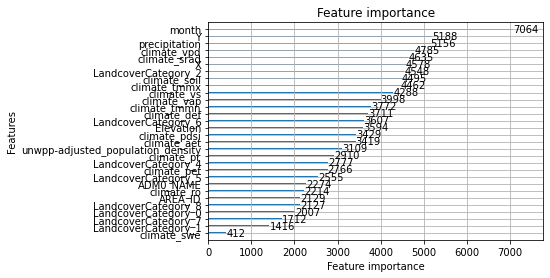

In [24]:
lgbm.plot_importance(model)

In [25]:
sub=test[["ID"]].copy()
sub["target"]=test_pred

In [26]:
sub.to_csv("Sub_numeric&categoricalfeatures.csv",index=False)

### Lag features 

In [27]:
# features of the last month 
data=pd.concat([train,test])
data.sort_values(["AREA_ID","year_month"],inplace=True)
num_features=['precipitation']
for col in num_features : 
    data[f"last_month_{col}"]=data.groupby("AREA_ID")[col].shift(1)

In [ ]:
# features of the last month 
data=pd.concat([train,test])
data.sort_values(["AREA_ID","year","month"],inplace=True)
num_features=['precipitation']
for col in num_features : 
    data[f"last_month_{col}"]=data.groupby("AREA_ID")[col].shift(1)

In [28]:
train=data[data.year!=2018]
test=data[data.year==2018]

In [29]:
X_train=train[train.year!=2017]
X_val=train[train.year==2017]

feature_drop=["ID","year_month","target","year"]
features=[feature for feature in X_train.columns if feature not in  feature_drop ]
features

['AREA_ID',
 'ADM0_NAME',
 'X',
 'Y',
 'month',
 'LandcoverCategory_0',
 'LandcoverCategory_1',
 'LandcoverCategory_2',
 'LandcoverCategory_3',
 'LandcoverCategory_4',
 'LandcoverCategory_5',
 'LandcoverCategory_6',
 'LandcoverCategory_7',
 'LandcoverCategory_8',
 'Elevation',
 'unwpp-adjusted_population_density',
 'precipitation',
 'climate_aet',
 'climate_def',
 'climate_pdsi',
 'climate_pet',
 'climate_pr',
 'climate_ro',
 'climate_soil',
 'climate_srad',
 'climate_swe',
 'climate_tmmn',
 'climate_tmmx',
 'climate_vap',
 'climate_vpd',
 'climate_vs',
 'last_month_precipitation']

In [30]:
test_pred,val_pred,model=lgbm_model(X_train,X_val,test,features,"target",params)

Training until validation scores don't improve for 50 rounds.
[200]	training's rmse: 0.126463	valid_1's rmse: 0.133447
[400]	training's rmse: 0.121301	valid_1's rmse: 0.129656
[600]	training's rmse: 0.118833	valid_1's rmse: 0.128232
[800]	training's rmse: 0.117179	valid_1's rmse: 0.127491
[1000]	training's rmse: 0.115836	valid_1's rmse: 0.126926
[1200]	training's rmse: 0.114547	valid_1's rmse: 0.126508
[1400]	training's rmse: 0.113373	valid_1's rmse: 0.126185
[1600]	training's rmse: 0.112397	valid_1's rmse: 0.126052
[1800]	training's rmse: 0.11146	valid_1's rmse: 0.12589
[2000]	training's rmse: 0.110529	valid_1's rmse: 0.125728
[2200]	training's rmse: 0.109656	valid_1's rmse: 0.125584
[2400]	training's rmse: 0.10881	valid_1's rmse: 0.12549
[2600]	training's rmse: 0.108018	valid_1's rmse: 0.125383
[2800]	training's rmse: 0.107195	valid_1's rmse: 0.125223
[3000]	training's rmse: 0.10639	valid_1's rmse: 0.125071
[3200]	training's rmse: 0.105654	valid_1's rmse: 0.125007
Early stopping, bes

In [31]:
sub=test[["ID"]].copy()
sub["target"]=test_pred

In [32]:
sub.to_csv("Sub_lag.csv",index=False)

In [33]:
### Random split 

In [34]:
from sklearn.model_selection import train_test_split 

In [35]:
X_train,X_val=train_test_split(train,test_size=0.1)

In [36]:
test_pred,val_pred,model=lgbm_model(X_train,X_val,test,features,"target",params)

Training until validation scores don't improve for 50 rounds.
[200]	training's rmse: 0.126935	valid_1's rmse: 0.126442
[400]	training's rmse: 0.121835	valid_1's rmse: 0.122719
[600]	training's rmse: 0.119422	valid_1's rmse: 0.121381
[800]	training's rmse: 0.117767	valid_1's rmse: 0.120566
[1000]	training's rmse: 0.116224	valid_1's rmse: 0.119916
[1200]	training's rmse: 0.114905	valid_1's rmse: 0.119426
[1400]	training's rmse: 0.113714	valid_1's rmse: 0.119097
[1600]	training's rmse: 0.112663	valid_1's rmse: 0.118795
[1800]	training's rmse: 0.11173	valid_1's rmse: 0.118535
[2000]	training's rmse: 0.110824	valid_1's rmse: 0.118297
[2200]	training's rmse: 0.109953	valid_1's rmse: 0.118071
[2400]	training's rmse: 0.109108	valid_1's rmse: 0.117911
[2600]	training's rmse: 0.108242	valid_1's rmse: 0.117716
[2800]	training's rmse: 0.107386	valid_1's rmse: 0.117544
[3000]	training's rmse: 0.10662	valid_1's rmse: 0.117378
[3200]	training's rmse: 0.105873	valid_1's rmse: 0.11729
[3400]	training's

In [37]:
sub=test[["ID"]].copy()
sub["target"]=test_pred

In [38]:
sub.to_csv("Sub_random_split.csv",index=False)

### Kfold 

In [39]:
import numpy as np 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error 
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))
    
def Kfold_train(train,test,features,params,target,n_splits=10): 
    train.reset_index(inplace=True,drop=True)
    kfold=KFold(n_splits=n_splits,random_state=2021,shuffle=True)
    oof_val=np.zeros_like(train[target])
    oof_test=[]
    for i ,(train_indx, val_index) in enumerate(kfold.split(train)) :
        X_train=train.iloc[train_indx]
        X_val=train.iloc[val_index] 
        test_pred,val_pred,model=lgbm_model(X_train,X_val,test,features,"target",params)
        oof_val[val_index]=val_pred
        oof_test.append(test_pred)
    
    
    print("validation score :",rmse(train[target],oof_val) )
    test_pred=np.mean(oof_test,0)
    return oof_val , test_pred



In [40]:
val_pred,test_pred=Kfold_train(train,test,features,params,"target")

Training until validation scores don't improve for 50 rounds.
[200]	training's rmse: 0.127074	valid_1's rmse: 0.125396
[400]	training's rmse: 0.121907	valid_1's rmse: 0.121203
[600]	training's rmse: 0.119504	valid_1's rmse: 0.119638
[800]	training's rmse: 0.11777	valid_1's rmse: 0.118724
[1000]	training's rmse: 0.116268	valid_1's rmse: 0.117976
[1200]	training's rmse: 0.114931	valid_1's rmse: 0.117337
[1400]	training's rmse: 0.113751	valid_1's rmse: 0.116871
[1600]	training's rmse: 0.112689	valid_1's rmse: 0.116483
[1800]	training's rmse: 0.111661	valid_1's rmse: 0.116128
[2000]	training's rmse: 0.110717	valid_1's rmse: 0.115856
[2200]	training's rmse: 0.109763	valid_1's rmse: 0.115567
[2400]	training's rmse: 0.108871	valid_1's rmse: 0.115302
[2600]	training's rmse: 0.107986	valid_1's rmse: 0.11505
[2800]	training's rmse: 0.107187	valid_1's rmse: 0.114855
[3000]	training's rmse: 0.10646	valid_1's rmse: 0.11468
[3200]	training's rmse: 0.105759	valid_1's rmse: 0.114528
[3400]	training's 

In [43]:
sub=test[["ID"]].copy()
sub["target"]=test_pred

In [44]:
sub.to_csv("Sub_Starter.csv",index=False)